In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2


import sys
sys.path.append("/Users/andrew/projects/bab-stablecoin_sims_research/demo/backend/simulator/PYLOB")

# from simulator.constants import *
# from simulator.market import Market
# from simulator.protocols import BasisProtocol
# from simulator.utils import *
# from simulator.traders import createTraderPool
from random import randint
from simulator import *
from matplotlib.pyplot import figure


%matplotlib inline

In [2]:
market = Market(Params({}))
basis = BasisProtocol(int(1e7), market)
market.protocol = basis
traderPool = createTraderPool(basis, market, market.params["trader_demographics"])
market.setTraderPool(traderPool)

market.usd_eth = 1 / get_eth_price(0, market)

trackers = {'usd_eth': [], 'bond_q_len': [], 'demand_ratio': [], 'ask_volume': [],
            'bid_volume': [], 'total_volume': [], 'circulation': []}

def track(trackers, market):
    trackers['usd_eth'].append(market.usd_eth)
    trackers['bond_q_len'].append(market.protocol.bondQueueLength)
    trackers['demand_ratio'].append(market.demandRatio)
    trackers['ask_volume'].append(market.askVolume)
    trackers['bid_volume'].append(market.bidVolume)
    trackers['total_volume'].append(market.totalVolume)
    trackers['circulation'].append(market.getCirculation())

L-1 Dev: 0.00190
L-2 Dev: 0.00001
L-inf Dev: 0.01389


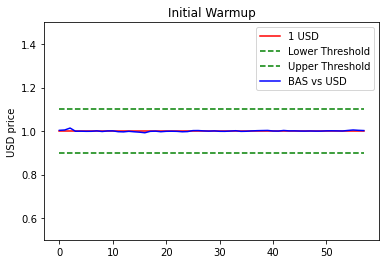

In [3]:
def warmup(market):
    NUM_TRADERS = market.params["trader_demographics"]['IdealTrader'] # We initially set it up with randomTraders

    for _ in range(market.params["NUM_ORDERS_INIT"]):
        market.usd_eth = 1.0 / get_eth_price(market.cur_time, market)
        
        tid = randint(1, NUM_TRADERS)
        orders = market.traderPool[tid].marketStep()
        for order in orders:
            market.processOrder(order)
        market.cur_time += 1
        
    # Keep demandRatio constant at 0.5 when we start the market
    market.demandRatio = 0.5

warmup(market)    
plot_prices(market, 'wavg_fair', warmup=100, ideal_dev=0.1, bin_size=50, title='Initial Warmup')

In [4]:
def trade(market, trackers):
    NUM_TRADERS = market.params["trader_demographics"]['AverageTrader'] + market.params["trader_demographics"]['BasicTrader']
    OFFSET_TRADERS = market.params["trader_demographics"]['IdealTrader']
    
    for i in range(market.params["NUM_ORDERS_LIVE"]):
        market.usd_eth = 1 / get_eth_price(market.cur_time, market) 
        if i % market.params["TRACK_FREQ"] == 0:
            track(trackers, market)
            
        tid = randint(OFFSET_TRADERS + 1, OFFSET_TRADERS + NUM_TRADERS)
        orders = market.traderPool[tid].marketStep()
        for order in orders:
            market.processOrder(order)    
        market.cur_time += 1

trade(market, trackers)

L-1 Dev: 0.01489
L-2 Dev: 0.00034
L-inf Dev: 0.08352


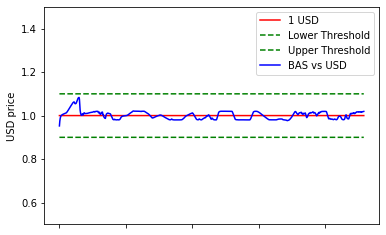

In [5]:
figure(figsize=(6, 4))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plot_prices(market, 'MAday', bin_size=50, warmup=market.params["NUM_ORDERS_INIT"])

Text(0, 0.5, 'Value')

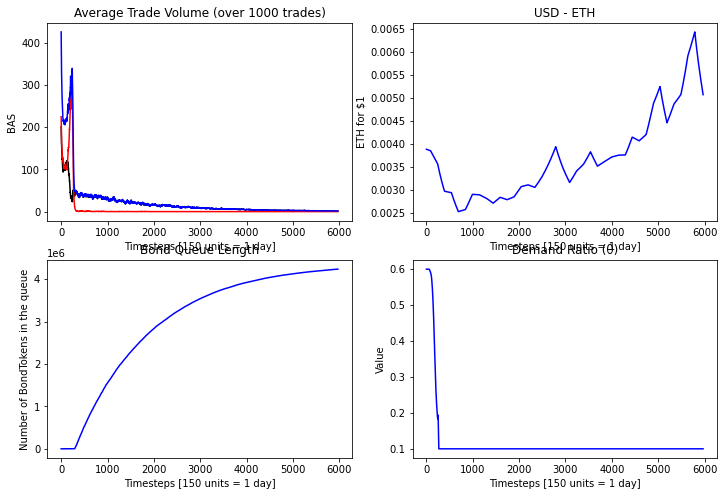

In [108]:
TRUNCATE = (NUM_ORDERS_INIT) // TRACK_FREQ

figure(figsize=(12,8))

plt.subplot(2, 2, 1)
plt.plot(trackers['ask_volume'][TRUNCATE:], 'k-')
plt.plot(trackers['bid_volume'][TRUNCATE:], 'r-')
plt.plot(trackers['total_volume'][TRUNCATE:], 'b-')
plt.title('Average Trade Volume (over 1000 trades)')
plt.xlabel('Timesteps [150 units = 1 day]')
plt.ylabel('BAS')

plt.subplot(2, 2, 2)
plt.plot(trackers['usd_eth'][TRUNCATE:], 'b-')
plt.title('USD - ETH')
plt.ylabel('ETH for $1')
plt.xlabel('Timesteps [150 units = 1 day]')

plt.subplot(2, 2, 3)
plt.plot(trackers['bond_q_len'][TRUNCATE:], 'b-')
plt.title('Bond Queue Length')
plt.xlabel('Timesteps [150 units = 1 day]')
plt.ylabel('Number of BondTokens in the queue')

plt.subplot(2, 2, 4)
plt.plot(trackers['demand_ratio'][TRUNCATE:], 'b-')
plt.title('Demand Ratio (θ)')
plt.xlabel('Timesteps [150 units = 1 day]')
plt.ylabel('Value')

# Don't need to plot this since circulation is circ0 - bond_queue length in essence
# plt.subplot(3, 2, 5)
# plt.plot(trackers['circulation'][TRUNCATE:], 'b-')
# plt.title('Circulation')
# plt.ylabel('$')

In [109]:
print (len(trackers['ask_volume']))
print(len(trackers['ask_volume'][TRUNCATE:]))
print (np.array(market.prices['MAday'])[NUM_ORDERS_INIT:].shape)

6000
5970
(396315,)


Text(0, 0.5, 'BAS')

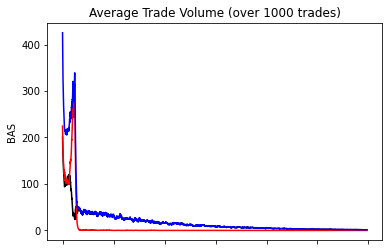

In [110]:
figure(figsize=(6,4))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.plot(trackers['ask_volume'][TRUNCATE:], 'k-')
plt.plot(trackers['bid_volume'][TRUNCATE:], 'r-')
plt.plot(trackers['total_volume'][TRUNCATE:], 'b-')
plt.title('Average Trade Volume (over 1000 trades)')
plt.ylabel('BAS')


Text(0, 0.5, 'ETH for $1')

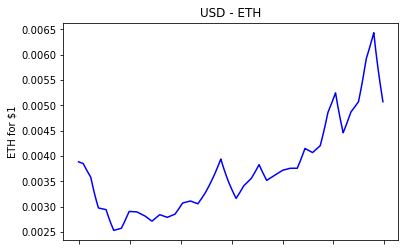

In [111]:
figure(figsize=(6,4))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.plot(trackers['usd_eth'][TRUNCATE:], 'b-')
plt.title('USD - ETH')
plt.ylabel('ETH for $1')

Text(0, 0.5, 'Number of BondTokens in the queue')

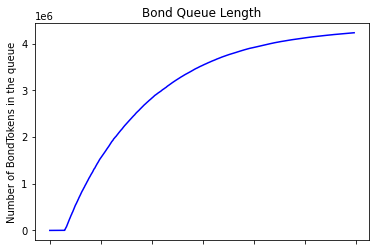

In [112]:
figure(figsize=(6,4))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.plot(trackers['bond_q_len'][TRUNCATE:], 'b-')
plt.title('Bond Queue Length')
plt.ylabel('Number of BondTokens in the queue')

Text(0, 0.5, 'Value')

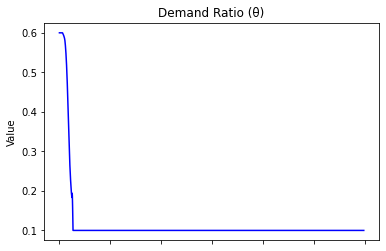

In [113]:
figure(figsize=(6,4))
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.plot(trackers['demand_ratio'][TRUNCATE:], 'b-')
plt.title('Demand Ratio (θ)')
plt.ylabel('Value')